# Imports

In [1]:
import numpy as np
import copy
import pandas as pd
import math, re, os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
import keras
from keras import layers, optimizers, metrics, Input, regularizers
from pathlib import Path
from functools import partial
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, cross_val_score
import cv2
from sklearn.utils.class_weight import compute_class_weight

import warnings

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.17.1


In [2]:
# As of now, there seems to be issues with Kaggle TPUs. Hence using GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available:", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available: 1
Num CPUs Available: 1


# Global variables

In [3]:
DIR_PATH = "/kaggle/input/siim-isic-melanoma-classification/"
TRAIN_PATH = DIR_PATH + "tfrecords/train*.tfrec"
TEST_PATH = DIR_PATH + "tfrecords/test*.tfrec"

#Since input jpegs are of varying size and mostly as large as 6000x4000 using the 512x512 dataset generously provided here
#                                  https://www.kaggle.com/competitions/siim-isic-melanoma-classification/discussion/164092
TRAIN_JPEG_PATH = "/kaggle/input/jpeg-melanoma-512x512/train/"  
TEST_JPEG_PATH = "/kaggle/input/jpeg-melanoma-512x512/test/"

TRAIN_TABDATA_PATH = DIR_PATH + "train.csv"
TEST_TABDATA_PATH = DIR_PATH + "test.csv"

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
BATCH_SIZE_TEST = 256
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 16
IMAGE_SIZE = [1024, 1024] # for TFRecord images
IMAGE_RESIZE = [128, 128]

STAGE1_EPOCHS = 10
STAGE2_EPOCHS = 5

#Does not support setting both TRAIN_VALID_SPLIT and TRAIN_ON_FULL_DATA as True 
TRAIN_VALID_SPLIT = True
TRAIN_ON_FULL_DATA = False
TEST_PREDICT = False
STAGE2 = False

RANDOM_SEED = 0

TABULAR_FEATURE_DIM = 10

CATEGORIES_SEX = ['male', 'female', 'unknown']
CATEGORIES_SITE = ['head/neck', 'upper extremity', 'lower extremity',
                   'torso', 'palms/soles', 'oral/genital', 'unknown']

MODEL_STAGE1_FILE_NAME = "effnetv2_s.keras"
MODEL_STAGE2_FILE_NAME = "effnetv2_s_stage2.keras"

MODEL_LOAD_FILE_PATH = "/kaggle/input/melanoma-classification/tensorflow2/effnetv2_s_1/3/effnetv2_s.keras"

if TRAIN_ON_FULL_DATA and TRAIN_VALID_SPLIT:
    raise Exception("Setting both TRAIN_VALID_SPLIT and TRAIN_ON_FULL_DATA as True not supported")

# Tabular data

In [4]:
train = pd.read_csv(TRAIN_TABDATA_PATH)
train["image_path"] = train["image_name"].apply(lambda x: os.path.join(TRAIN_JPEG_PATH, f"{x}.jpg"))
test = pd.read_csv(TEST_TABDATA_PATH)

In [5]:
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  \
0   unknown           benign       0   
1   unknown           benign       0   
2     nevus           benign       0   
3   unknown           benign       0   
4   unknown           benign       0   

                                          image_path  
0  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
1  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
2  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
3  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
4  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...

In [6]:
test.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

# EDA

In [7]:
print(train.shape, test.shape)

(33126, 9) (10982, 5)


## Mising values

In [8]:
print("Train")
print(train.isna().sum())

print("\n----------------\n")

print("Test")
print(test.isna().sum())

Train
image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
image_path                         0
dtype: int64

----------------

Test
image_name                         0
patient_id                         0
sex                                0
age_approx                         0
anatom_site_general_challenge    351
dtype: int64


We can replace null values in the columns sex and anatom_site with "unknown".
Lets check what to replace null values in age_approx with.

In [9]:
train.age_approx.describe()

count    33058.000000
mean        48.870016
std         14.380360
min          0.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64

In [10]:
sum(train.age_approx == 0)

2

There are age 0s ! Lets check the rows.

In [11]:
train.loc[train.age_approx == 0, :]

image_name  patient_id   sex  age_approx  \
9647   ISIC_2988939  IP_1300691  male         0.0   
22645  ISIC_6872638  IP_1300691  male         0.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  \
9647                          torso   unknown           benign       0   
22645                         torso   unknown           benign       0   

                                              image_path  
9647   /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
22645  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...

Age 0s are just for 1 patient. Does this patient have other entries ?

In [12]:
train.loc[train.patient_id == "IP_1300691", :]

image_name  patient_id   sex  age_approx  \
3019   ISIC_1005683  IP_1300691  male        10.0   
9647   ISIC_2988939  IP_1300691  male         0.0   
22645  ISIC_6872638  IP_1300691  male         0.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  \
3019                          torso   unknown           benign       0   
9647                          torso   unknown           benign       0   
22645                         torso   unknown           benign       0   

                                              image_path  
3019   /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
9647   /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
22645  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...

Looks like the 0 is a data entry error and should be 10 instead. 

But do same patients have different age ? (i.e. does data contain images across different years ?) 

In [13]:
diff_age_patients = train.dropna(subset="age_approx").groupby("patient_id")["age_approx"].agg(["min", "max", "median", "count"])
diff_age_patients["diff"] = diff_age_patients["max"] - diff_age_patients["min"]
diff_age_patients.sort_values("diff", ascending=False)

min   max  median  count  diff
patient_id                                 
IP_0843629  25.0  45.0    35.0     32  20.0
IP_1557123  25.0  45.0    25.0     15  20.0
IP_4204657  40.0  60.0    45.0     38  20.0
IP_3679859  20.0  40.0    35.0     17  20.0
IP_8678278  20.0  40.0    35.0     39  20.0
...          ...   ...     ...    ...   ...
IP_4302652  20.0  20.0    20.0     39   0.0
IP_4268080  45.0  45.0    45.0      4   0.0
IP_4267931  55.0  55.0    55.0      9   0.0
IP_4263066  65.0  65.0    65.0      3   0.0
IP_4379852  60.0  60.0    60.0     12   0.0

[2053 rows x 5 columns]

In [14]:
train.loc[train.patient_id == "IP_6796539", :]

image_name  patient_id     sex  age_approx  \
587    ISIC_0281658  IP_6796539  female        30.0   
1460   ISIC_0539380  IP_6796539  female        30.0   
9530   ISIC_2955610  IP_6796539  female        40.0   
9669   ISIC_2996391  IP_6796539  female        25.0   
14187  ISIC_4351248  IP_6796539  female        40.0   
18216  ISIC_5549768  IP_6796539  female        35.0   
20078  ISIC_6099309  IP_6796539  female        25.0   
20813  ISIC_6323489  IP_6796539  female        20.0   
21382  ISIC_6486856  IP_6796539  female        35.0   
21442  ISIC_6506429  IP_6796539  female        25.0   
21520  ISIC_6530659  IP_6796539  female        30.0   
21550  ISIC_6538955  IP_6796539  female        25.0   
22298  ISIC_6758042  IP_6796539  female        35.0   
27812  ISIC_8419036  IP_6796539  female        35.0   
28707  ISIC_8681917  IP_6796539  female        20.0   
29436  ISIC_8898680  IP_6796539  female        40.0   
30302  ISIC_9153636  IP_6796539  female        30.0   
32656  ISIC_9859594  IP_6796539  female        30.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  \
587                           torso   unknown           benign       0   
1460                          torso   unknown           benign       0   
9530                upper extremity   unknown           benign       0   
9669                    palms/soles   unknown           benign       0   
14187                   palms/soles   unknown           benign       0   
18216               lower extremity   unknown           benign       0   
20078                         torso   unknown           benign       0   
20813               upper extremity   unknown           benign       0   
21382               lower extremity   unknown           benign       0   
21442               upper extremity   unknown           benign       0   
21520               lower extremity   unknown           benign       0   
21550                   palms/soles   unknown           benign       0   
22298                         torso   unknown           benign       0   
27812               upper extremity   unknown           benign       0   
28707                         torso   unknown           benign       0   
29436                   palms/soles   unknown           benign       0   
30302                         torso   unknown           benign       0   
32656                         torso   unknown           benign       0   

                                              image_path  
587    /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
1460   /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
9530   /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
9669   /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
14187  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
18216  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
20078  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
20813  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
21382  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
21442  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
21520  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
21550  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
22298  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
27812  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
28707  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
29436  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
30302  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...  
32656  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...

Looks like having images of a patient across different age is a common occurrence. 

In [15]:
train.age_approx.unique(), test.age_approx.unique()

(array([45., 50., 55., 40., 25., 35., 30., 75., 70., 65., 60., nan, 80.,
        20., 85., 15., 90., 10.,  0.]),
 array([70., 40., 55., 50., 45., 65., 60., 30., 85., 35., 80., 25., 15.,
        20., 75., 90., 10.]))

age_approx values are in multiples of 5. Test data does not contain age_approx=0 from info above.

We'll keep age_approx = 0 rows unchanged. Could be that these images were taken at age 2 or less, so that its approximated to 0.

In [16]:
train.loc[train.age_approx != 0, :].describe()

age_approx        target
count  33056.000000  33124.000000
mean      48.872973      0.017631
std       14.375770      0.131607
min       10.000000      0.000000
25%       40.000000      0.000000
50%       50.000000      0.000000
75%       60.000000      0.000000
max       90.000000      1.000000

There are 2 rows with values 0. So missing values can't be replaced with 0. 

We'll replace missing values with -10 for visualization purpose and also include age_missing column.

In [17]:
train["sex"] = train["sex"].fillna("unknown")

train["anatom_site_general_challenge"] = train["anatom_site_general_challenge"].fillna("unknown")
test["anatom_site_general_challenge"] = test["anatom_site_general_challenge"].fillna("unknown")

train["age_missing"] = train.age_approx.isna()
train["age_missing"] = train["age_missing"].astype(int)

test["age_missing"] = test.age_approx.isna()
test["age_missing"] = test["age_missing"].astype(int)

train["age_approx"] = train["age_approx"].fillna(-10)

In [18]:
train.age_approx.unique(), test.age_approx.unique()

(array([ 45.,  50.,  55.,  40.,  25.,  35.,  30.,  75.,  70.,  65.,  60.,
        -10.,  80.,  20.,  85.,  15.,  90.,  10.,   0.]),
 array([70., 40., 55., 50., 45., 65., 60., 30., 85., 35., 80., 25., 15.,
        20., 75., 90., 10.]))

In [19]:
print("Train")
print(train.isna().sum())

print("\n----------------\n")

print("Test")
print(test.isna().sum())

Train
image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
image_path                       0
age_missing                      0
dtype: int64

----------------

Test
image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
age_missing                      0
dtype: int64


In [20]:
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  \
0   unknown           benign       0   
1   unknown           benign       0   
2     nevus           benign       0   
3   unknown           benign       0   
4   unknown           benign       0   

                                          image_path  age_missing  
0  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...            0  
1  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...            0  
2  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...            0  
3  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...            0  
4  /kaggle/input/jpeg-melanoma-512x512/train/ISIC...            0

In [21]:
test.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_0052060  IP_3579794    male        70.0                       unknown   
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity   
2  ISIC_0058510  IP_7960270  female        55.0                         torso   
3  ISIC_0073313  IP_6375035  female        50.0                         torso   
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity   

   age_missing  
0            0  
1            0  
2            0  
3            0  
4            0

## Target distribution

In [22]:
target_counts = train.target.value_counts()
target_counts

target
0    32542
1      584
Name: count, dtype: int64

In [23]:
target_counts[0]*100/sum(target_counts), target_counts[1]*100/sum(target_counts)

(98.23703435367989, 1.762965646320111)

98.237 % of images are of benign cases and only 1.762 % is of malignant case.

## Unique images

In [24]:
print(train.shape, test.shape)
print(len(train.image_name.unique()), len(test.image_name.unique()))

(33126, 10) (10982, 6)
33126 10982


So all images are unique in both train and test

## Images per patient

In [25]:
train_patientids = pd.DataFrame(train.patient_id.value_counts())
display(train_patientids.describe())
test_patientids = pd.DataFrame(test.patient_id.value_counts())
display(test_patientids.describe())

count
count  2056.000000
mean     16.111868
std      15.674491
min       2.000000
25%       5.000000
50%      12.000000
75%      22.000000
max     115.000000

count
count  690.000000
mean    15.915942
std     16.735157
min      3.000000
25%      6.000000
50%     10.000000
75%     21.000000
max    240.000000

In [26]:
def hist_and_box(df, col_name, main_title, title, hist_xlabel, bin_range=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.histplot(data=df[col_name].values, binwidth=5, binrange=bin_range, kde=True, ax=axes[0])
    axes[0].set_title("Histogram of " + title)
    axes[0].set_xlabel(hist_xlabel)
    axes[0].set_ylabel("Frequency")
    
    sns.boxplot(data=df[col_name].values, ax=axes[1])
    axes[1].set_title("Boxplot of " + title)
    axes[1].set_ylabel(hist_xlabel)

    plt.suptitle(main_title)
    
    plt.tight_layout()
    plt.show()

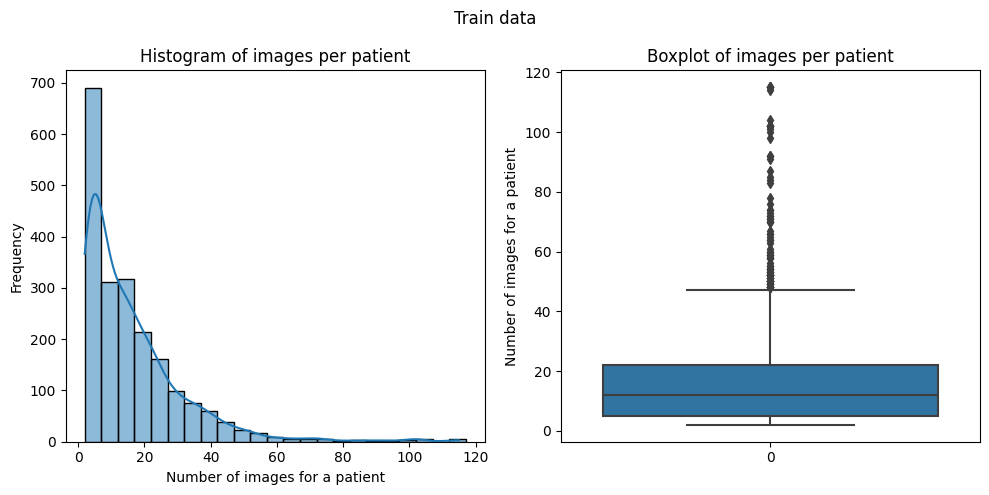

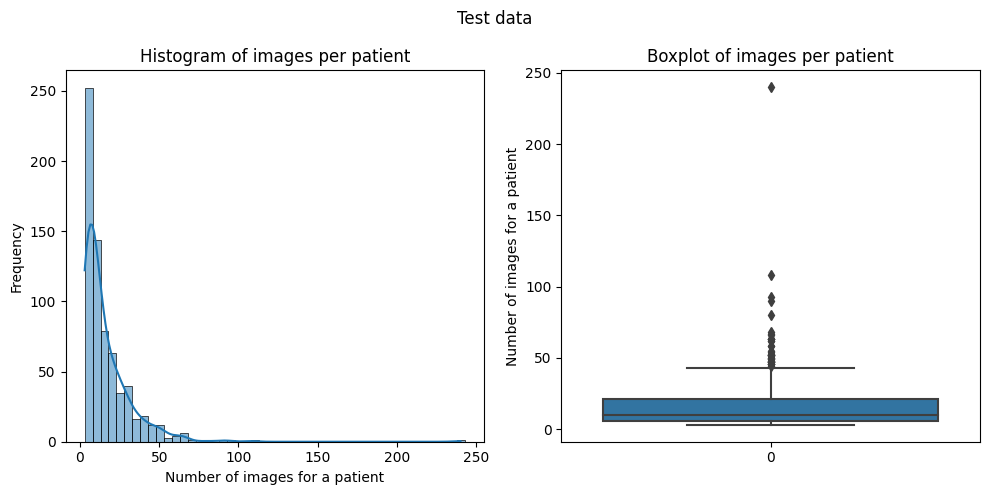

In [27]:
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

hist_and_box(train_patientids, "count", "Train data", "images per patient", "Number of images for a patient")

hist_and_box(test_patientids, "count", "Test data", "images per patient", "Number of images for a patient")

## Patient ID overlap

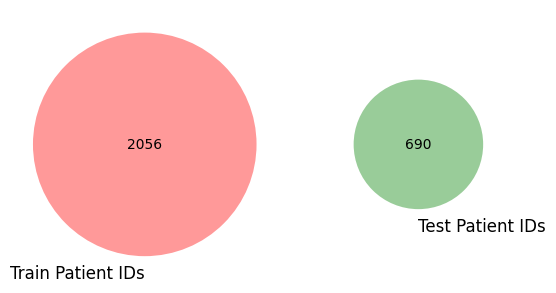

In [28]:
venn2(subsets = (set(train.patient_id.unique()), set(test.patient_id.unique())),
      set_labels = ('Train Patient IDs', 'Test Patient IDs'))
plt.show()

There are no common patient ids b/w train and test. For train-validation split, we'll need to ensure the same.

## Sex

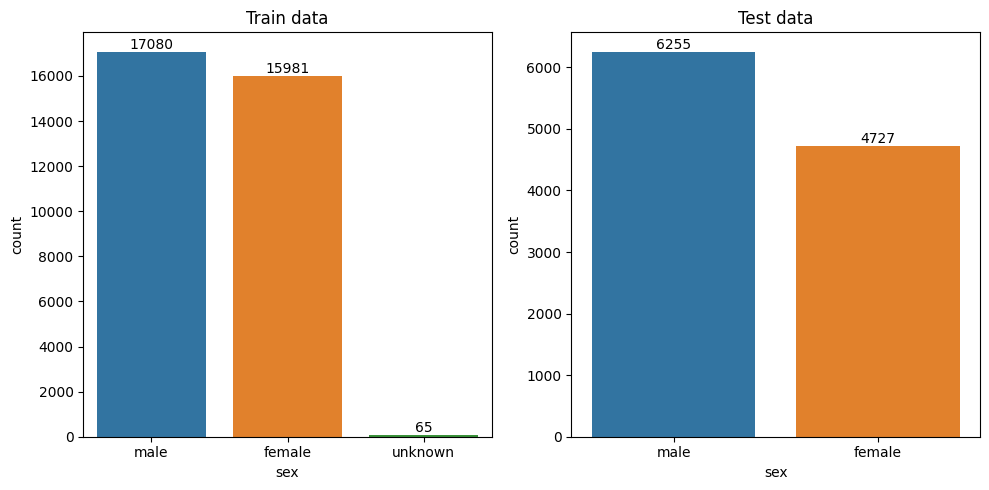

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(data=train, x="sex", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_title("Train data")

axes[1] = sns.countplot(data=test, x="sex", ax=axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)
axes[1].set_title("Test data")    

plt.tight_layout() 
plt.show()

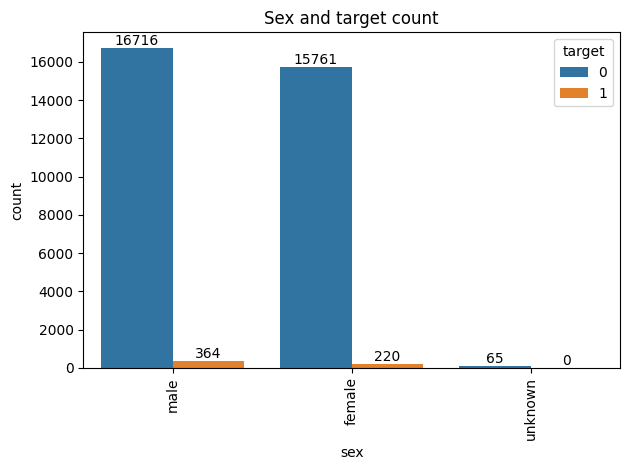

In [30]:
ax = sns.countplot(data=train, x="sex",
                   hue="target")
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Sex and target count")
ax.tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

## Anatomical site

In [31]:
print(np.sort(train.anatom_site_general_challenge.unique()))
print(np.sort(test.anatom_site_general_challenge.unique()))

['head/neck' 'lower extremity' 'oral/genital' 'palms/soles' 'torso'
 'unknown' 'upper extremity']
['head/neck' 'lower extremity' 'oral/genital' 'palms/soles' 'torso'
 'unknown' 'upper extremity']


In [32]:
anatom_site_order = train.anatom_site_general_challenge.value_counts().index
anatom_site_order

Index(['torso', 'lower extremity', 'upper extremity', 'head/neck', 'unknown',
       'palms/soles', 'oral/genital'],
      dtype='object', name='anatom_site_general_challenge')

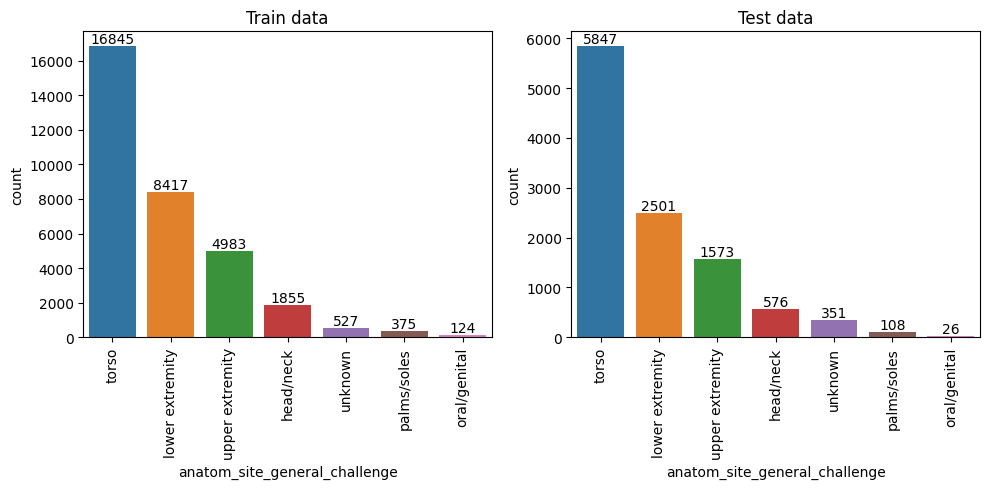

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(data=train, x="anatom_site_general_challenge", 
              order=anatom_site_order,
              ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_title("Train data")
axes[0].tick_params(axis='x', labelrotation=90)

sns.countplot(data=test, x="anatom_site_general_challenge",
              order=anatom_site_order,
              ax=axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)
axes[1].set_title("Test data")   
axes[1].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

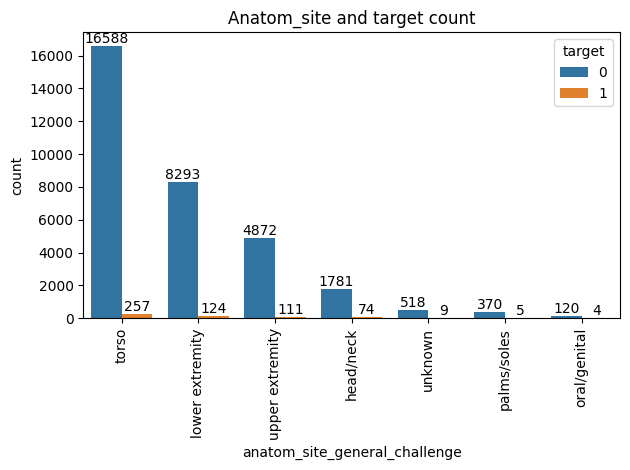

In [34]:
ax = sns.countplot(data=train, x="anatom_site_general_challenge",
                   hue="target",
                   order=anatom_site_order)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Anatom_site and target count")
ax.tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

## Age

In [35]:
print("Train")
print(train.age_approx.describe())

print("\n----------------\n")

print("Test")
print(test.age_approx.describe())

Train
count    33126.000000
mean        48.749170
std         14.610616
min        -10.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64

----------------

Test
count    10982.000000
mean        49.525587
std         14.370589
min         10.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64


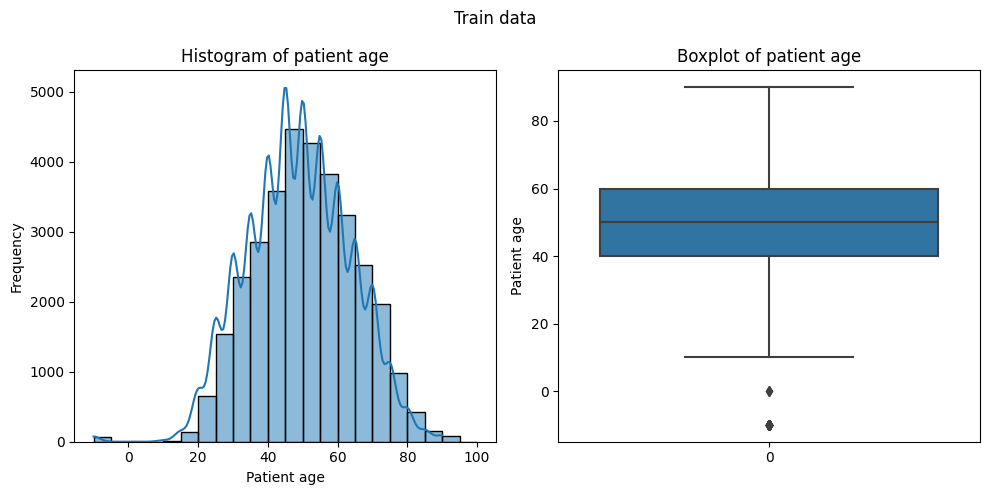

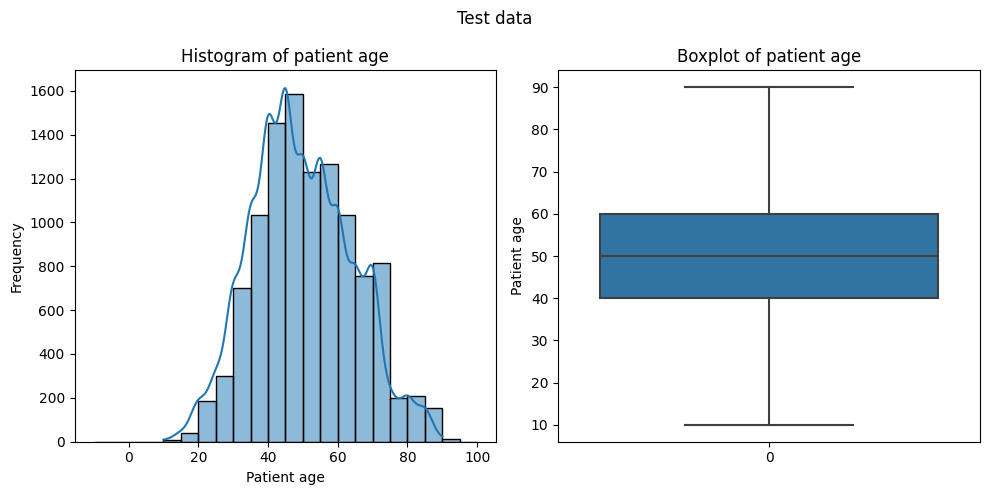

In [36]:
hist_and_box(train, "age_approx", "Train data", "patient age", "Patient age", (-10,100))
hist_and_box(test, "age_approx", "Test data", "patient age", "Patient age", (-10,100))

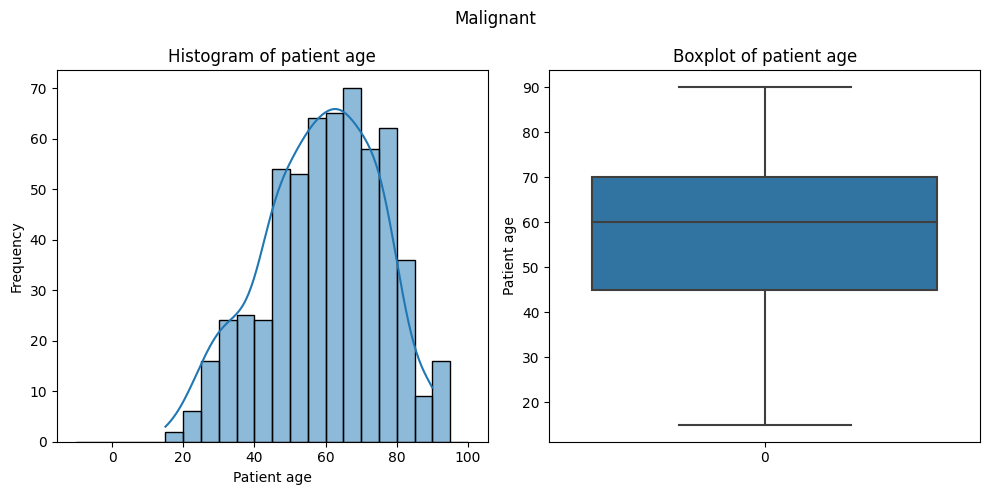

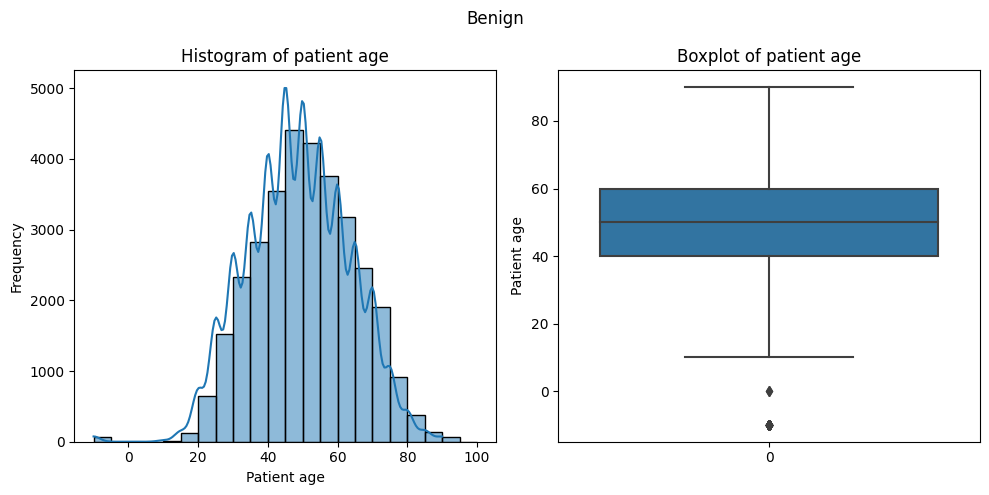

In [37]:
hist_and_box(train.loc[train.target==1, :], "age_approx", "Malignant", "patient age", "Patient age", (-10,100))
hist_and_box(train.loc[train.target==0, :], "age_approx", "Benign", "patient age", "Patient age", (-10,100))

In [38]:
train.loc[(train.target==1) & (train.age_approx==-10.0), :]

Empty DataFrame
Columns: [image_name, patient_id, sex, age_approx, anatom_site_general_challenge, diagnosis, benign_malignant, target, image_path, age_missing]
Index: []

The proportion of categories of sex, anatom_site, age_approx seem to be visibly similar in train and test data. So that need not be an additional consideration during train-validation split.

# Check images

Examples : Malignant (With Melanoma)


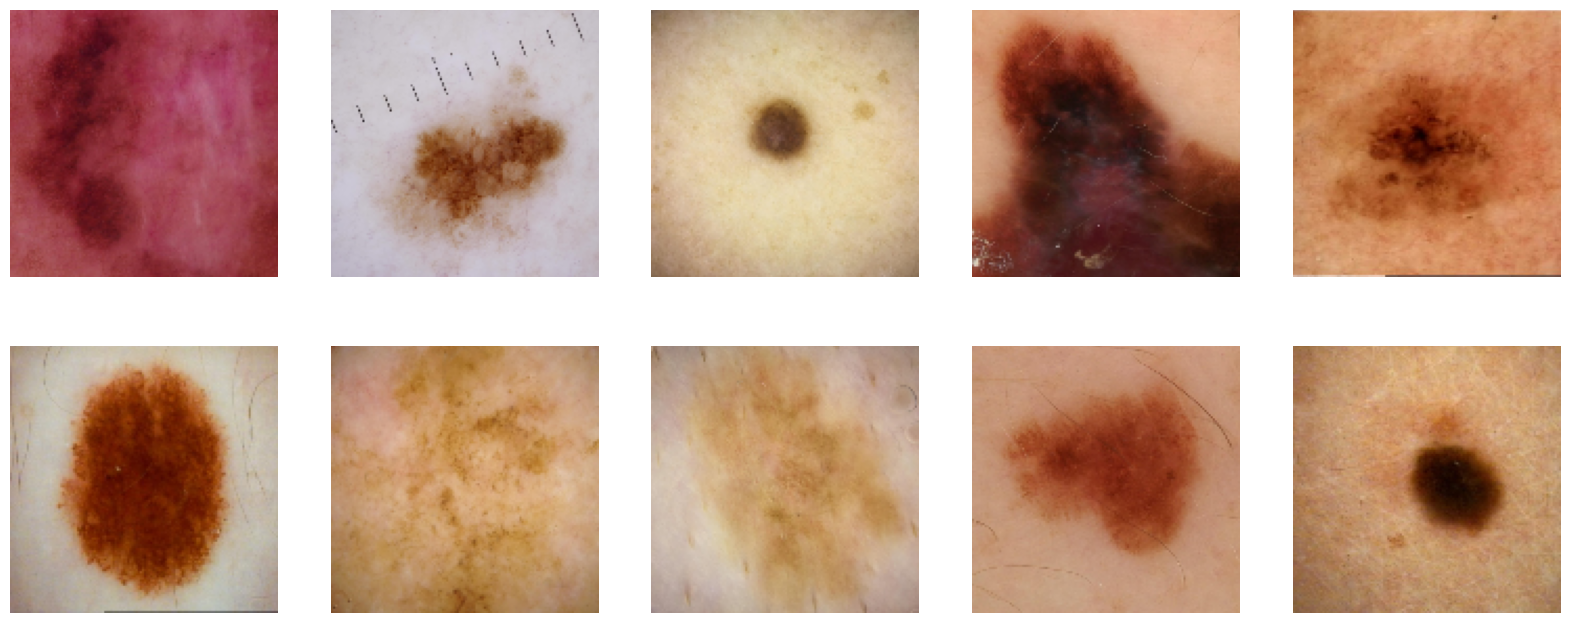

Examples : Benign (Without Melanoma)


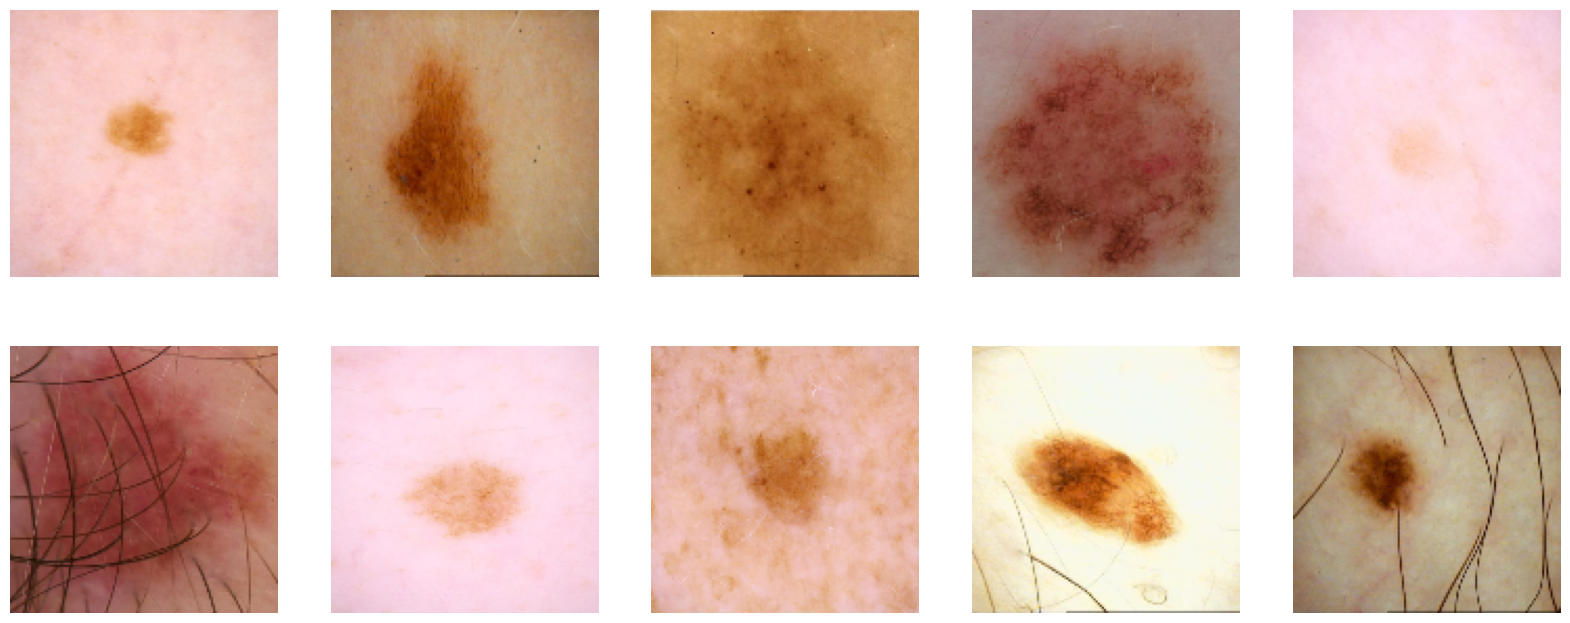

In [39]:
print("Examples : Malignant (With Melanoma)")
imgs = train.loc[train.target==1].sample(10).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread(TRAIN_JPEG_PATH + k + ".jpg")
    img = cv2.resize(img, IMAGE_RESIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()

print("Examples : Benign (Without Melanoma)")
imgs = train.loc[train.target==0].sample(10).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread(TRAIN_JPEG_PATH + k + ".jpg")
    img = cv2.resize(img, IMAGE_RESIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()

# Load data

## get_tabular_features

In [40]:
def get_tabular_features(df):
    """ 
        return tabular_features one-hot encoded for use with jpeg image data 
           and dense_hash hashtable for use with TFRecord
    """

    tabular_features = pd.get_dummies(df, columns=["sex", "anatom_site_general_challenge"], dtype=np.float32)

    #represent unknown of both columns with all 0s in 1-hot encoding
    drop_columns = ["sex_unknown", "anatom_site_general_challenge_unknown"]
    tabular_features.drop(columns=[c for c in drop_columns if c in tabular_features.columns], inplace=True) 
    
    required_columns = (["sex_"+col for col in CATEGORIES_SEX[:-1]] +
                        ["age_approx", "age_missing"] +
                        ["anatom_site_general_challenge_"+col for col in CATEGORIES_SITE[:-1]])
    tabular_features = tabular_features[required_columns]

    dense_hash = tf.lookup.experimental.DenseHashTable(key_dtype=tf.string,
                                                       value_dtype=tf.float32,
                                                       default_value=tf.constant([-1.0] * len(required_columns), dtype=tf.float32),
                                                       empty_key='',
                                                       deleted_key='$')
    dense_hash.insert(tf.constant(df["image_name"].values), 
                      tf.constant(tabular_features.values.tolist(), dtype=tf.float32))

    return tabular_features, dense_hash

## decode_image

In [41]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_RESIZE)
    return image

## Load TFRecord data

In [42]:
# uncomment code below to see raw tfrecord info and verify data type

# raw_dataset = tf.data.TFRecordDataset("/kaggle/input/siim-isic-melanoma-classification/tfrecords/train09-2071.tfrec")
# for raw_record in raw_dataset.take(5):
#     example = tf.train.Example()
#     example.ParseFromString(raw_record.numpy())
#     print(example)

In [43]:
def read_tfrecord(example, dense_hash, labeled):
    tfrecord_format = {
        "image"                        : tf.io.FixedLenFeature([], tf.string),
        "image_name"                   : tf.io.FixedLenFeature([], tf.string),      
        "target"                       : tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image"                        : tf.io.FixedLenFeature([], tf.string),          
        "image_name"                   : tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image_name = example["image_name"]
    image = decode_image(example["image"])
    tabular_features = dense_hash.lookup(image_name)
    tabular_features = tf.ensure_shape(tabular_features, (TABULAR_FEATURE_DIM,)) 
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return (image, tabular_features), label
    return (image, tabular_features), image_name

def load_dataset(filenames, dense_hash, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, dense_hash=dense_hash, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [44]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH) 
test_filenames = tf.io.gfile.glob(TEST_PATH)

print('Train TFRecord Files:', len(train_filenames))
print('Test TFRecord Files:', len(test_filenames))

Train TFRecord Files: 16
Test TFRecord Files: 16


In [45]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

num_training_images = count_data_items(train_filenames)
num_test_images = count_data_items(test_filenames)
print(
    'Dataset: {} training images, {} unlabeled test images'.format(
        num_training_images, num_test_images
    )
)

Dataset: 33126 training images, 10982 unlabeled test images


## Load jpeg data

In [46]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = decode_image(image)
    return image

def process_data(image_path, label, tabular_row):
    return (load_image(image_path), tf.cast(tabular_row, tf.float32)), tf.cast(label, tf.int32)

def load_jpeg_dataset(image_paths, labels, tabular_data):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels, tabular_data))
    dataset = dataset.map(lambda x, y, z: process_data(x, y, z), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Data Augmentation

Uncomment the code below to visualize augmentations used. Using cat image sometimes seems easier to visualize augmentations !

In [47]:
# Visualize augmentations

# image = tf.io.decode_jpeg(tf.io.read_file("/kaggle/input/jpeg-melanoma-512x512/train/ISIC_0149568.jpg"))  # malignant
# image = tf.io.decode_jpeg(tf.io.read_file("/kaggle/input/jpeg-melanoma-512x512/train/ISIC_2637011.jpg"))  # benign
# image = tf.io.decode_jpeg(tf.io.read_file("/kaggle/input/cat-image/cat.jpg"))                             # cat image

# image = tf.image.resize(image, (224, 224)) / 255.0
# image = tf.expand_dims(image, axis=0)  # Add batch dimension

# num_samples = 6

# random_layer = layers.RandomZoom((-0.2, 0.2), (-0.2, 0.2), fill_mode="nearest")
# random_layer = layers.RandomRotation(0.5, fill_mode="nearest")
# random_layer = layers.RandomFlip(mode="horizontal_and_vertical")
# random_layer = layers.RandomBrightness(0.15, value_range=(0, 1))

## Generate augmented images
# augmented_images = [random_layer(image, training=True)[0].numpy() for _ in range(num_samples)]

# # code to apply conditional_augmentation-----------------------
# layer_flip = layers.RandomFlip(mode="horizontal_and_vertical")
# layer_zoom = layers.RandomZoom((-0.2, 0.2), (-0.2, 0.2), fill_mode="nearest")
# layer_brightness = layers.RandomBrightness(0.15, value_range=(0, 1))
# def augmentation_pipeline(image):
#     rand_num = tf.random.uniform(())
    
#     def apply_flip(): return layer_flip(image)
#     def apply_zoom(): return layer_zoom(image)
#     def apply_brightness(): return layer_brightness(image)
    
#     image = tf.case([
#         (tf.logical_and(rand_num >= 0.25, rand_num < 0.5), apply_flip),
#         (tf.logical_and(rand_num >= 0.5, rand_num < 0.75), apply_zoom),
#         (rand_num >= 0.75, apply_brightness),
#     ], default=lambda: (image))  # No augmentation for rand_num < 0.25
    
#     return image
# augmented_images = [augmentation_pipeline(image)[0].numpy() for _ in range(num_samples)]
# # code to apply conditional_augmentation end-----------------------

# # Plot the original and augmented images
# fig, axes = plt.subplots(1, num_samples + 1, figsize=(15, 5))
# axes[0].imshow(image[0])
# axes[0].set_title("Original")
# axes[0].axis("off")

# for i in range(num_samples):
#     axes[i + 1].imshow(augmented_images[i])
#     axes[i + 1].set_title(f"Augmented {i+1}")
#     axes[i + 1].axis("off")

# plt.tight_layout()
# plt.show()

In [48]:
layer_flip = layers.RandomFlip(mode="horizontal_and_vertical")
layer_zoom = layers.RandomZoom((-0.2, 0.2), (-0.2, 0.2), fill_mode="nearest")
layer_brightness = layers.RandomBrightness(0.15, value_range=(0, 255))

def augmentation_pipeline(data, label):
    image, tab_features = data
    
    rand_num = tf.random.uniform(())
    
    def apply_flip(): return layer_flip(image)
    def apply_zoom(): return layer_zoom(image)
    def apply_brightness(): return layer_brightness(image)
    
    image = tf.case([
        (tf.logical_and(rand_num >= 0.25, rand_num < 0.5), apply_flip),
        (tf.logical_and(rand_num >= 0.5, rand_num < 0.75), apply_zoom),
        (rand_num >= 0.75, apply_brightness),
    ], default=lambda: image)  # No augmentation for rand_num < 0.25
    
    return (image, tab_features), label

# Get datasets

In [49]:
#For tfrecord, pass tfrecord=True and provide dense_hash as tabular_data and also provide filenames
#For jpeg, pass tfrecord=False and provide image_paths and labels and tabular_features as tabular_data

def get_training_dataset(tfrecord=True, filenames=None, image_paths=None, labels=None, tabular_data=None):
    if tfrecord:
        dataset = load_dataset(filenames, dense_hash=tabular_data, labeled=True)
    else: #jpeg
        dataset = load_jpeg_dataset(image_paths, labels, tabular_data)
    dataset = dataset.map(augmentation_pipeline, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(tfrecord=True, filenames=None, image_paths=None, labels=None, tabular_data=None):
    if tfrecord:
        dataset = load_dataset(filenames, dense_hash=tabular_data, labeled=True) 
    else: #jpeg
        dataset = load_jpeg_dataset(image_paths, labels, tabular_data)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(filenames=None, tabular_data=None):   # only use TFRecord for predicting test data
    dataset = load_dataset(filenames, dense_hash=tabular_data, labeled=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# show_batch

In [50]:
def show_batch(image_batch, tab_data_batch, label_batch):
    plt.figure(figsize=(10,10))
    image_batch = tf.cast(image_batch, tf.float32) / 255.0
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])

        label = "Malignant" if label_batch[n] else "Benign"
        tabular_info = tab_data_batch[n].round(2)

        sex = "male" if tabular_info[0] else "female" if tabular_info[1] else "unknown"
        age = tabular_info[2]
        age_missing = (tabular_info[2] == 1)
        a_site = CATEGORIES_SITE[np.where(tabular_info[4:])[0][0] if sum(tabular_info[4:]) else 6]
        
        plt.title(f"{label}\n{tabular_info}\nSex : {sex}\n Age : {age} Age_missing : {age_missing}\n Anatomical Site : {a_site}", 
                  fontsize=6)
        
        plt.axis("off")

    plt.tight_layout()
    plt.show()

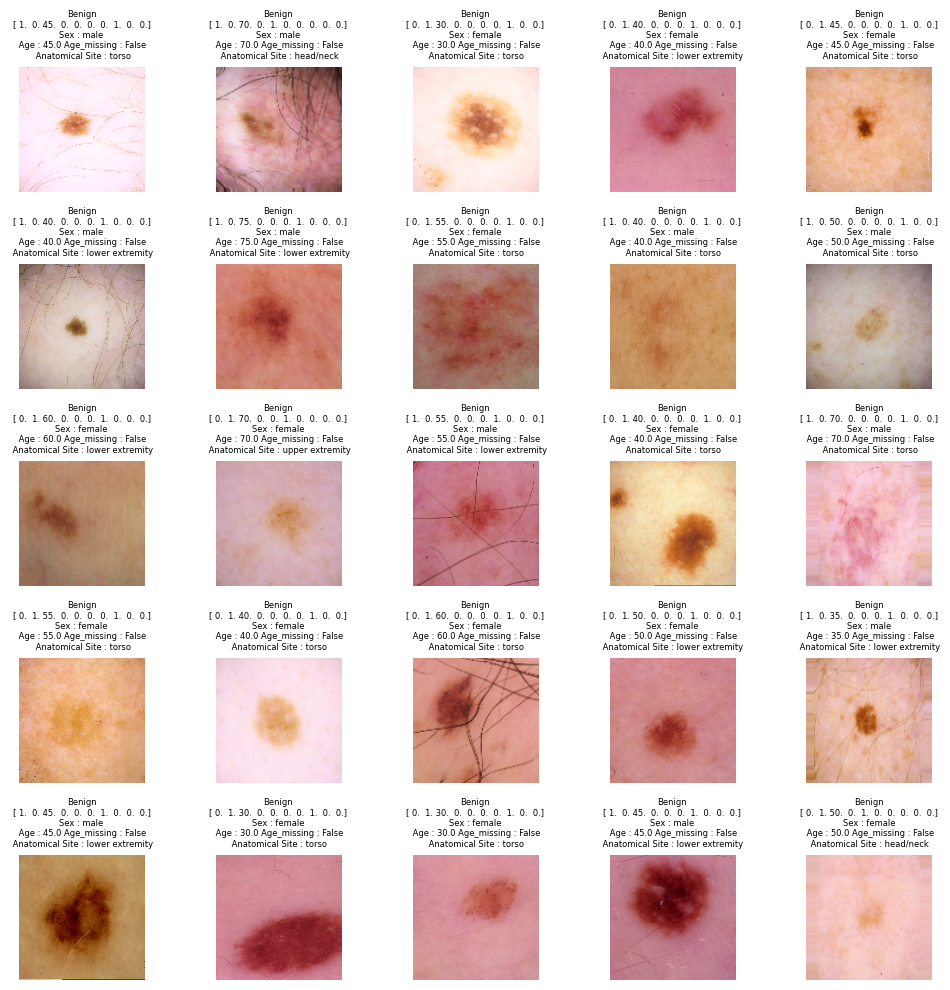

In [51]:
_, train_hash = get_tabular_features(train)
train_dataset = get_training_dataset(filenames=train_filenames, tabular_data=train_hash)

(image_batch, tab_data_batch), label_batch = next(iter(train_dataset))
show_batch(image_batch.numpy(), tab_data_batch.numpy(), label_batch.numpy())

# Train validation split using jpeg data

Since TFRecord images are grouped together into different files, performing train-validation split using patientid column would be easier with jpeg files.

Lets perform 80-20 train-validation split taking into account the columns : target and patientid. Train and validation datasets need 
* equal proportion of target column values.
* non-overlapping sets of patientids

In [52]:
train_index, valid_index = next(StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED).split(train.image_name, train.target, train.patient_id))

print(len(train_index), len(valid_index))
print(len(train_index)/train.shape[0], len(valid_index)/train.shape[0])

26542 6584
0.8012437360381574 0.19875626396184265


The rest of the 4 splits generated above can be used, but here we'll only use the 1st split for quick iteration and then train on full data once we identify the best model and hyperparams.

In [53]:
train_data = train.loc[train_index, :]
valid_data = train.loc[valid_index, :]

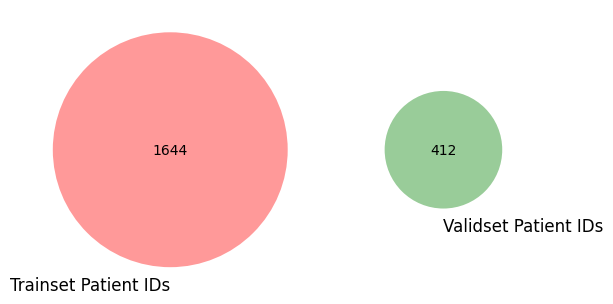

In [54]:
venn2(subsets = (set(train_data.patient_id.unique()), 
                 set(valid_data.patient_id.unique())),
      set_labels = ('Trainset Patient IDs', 'Validset Patient IDs'))
plt.show()

As expected, it is non-overlapping

In [55]:
t_target_counts = train_data.target.value_counts()
print(t_target_counts[0]*100/sum(t_target_counts), t_target_counts[1]*100/sum(t_target_counts))

v_target_counts = valid_data.target.value_counts()
print(v_target_counts[0]*100/sum(v_target_counts), v_target_counts[1]*100/sum(v_target_counts))

98.24429206540577 1.755707934594228
98.20777642770352 1.7922235722964763


Proportion of target categories is same in train and validation

In [56]:
print(train_data.sex.value_counts())
print(valid_data.sex.value_counts())

sex
male       13574
female     12903
unknown       65
Name: count, dtype: int64
sex
male      3506
female    3078
Name: count, dtype: int64


All the samples with unknown sex are in train and not in valid, similar to that in full train and test.

In [57]:
print(train_data.anatom_site_general_challenge.value_counts())
print(valid_data.anatom_site_general_challenge.value_counts())

anatom_site_general_challenge
torso              13462
lower extremity     6786
upper extremity     4053
head/neck           1507
unknown              352
palms/soles          287
oral/genital          95
Name: count, dtype: int64
anatom_site_general_challenge
torso              3383
lower extremity    1631
upper extremity     930
head/neck           348
unknown             175
palms/soles          88
oral/genital         29
Name: count, dtype: int64


Proportion of anatom_site_general_challenge is also similar in train and valid

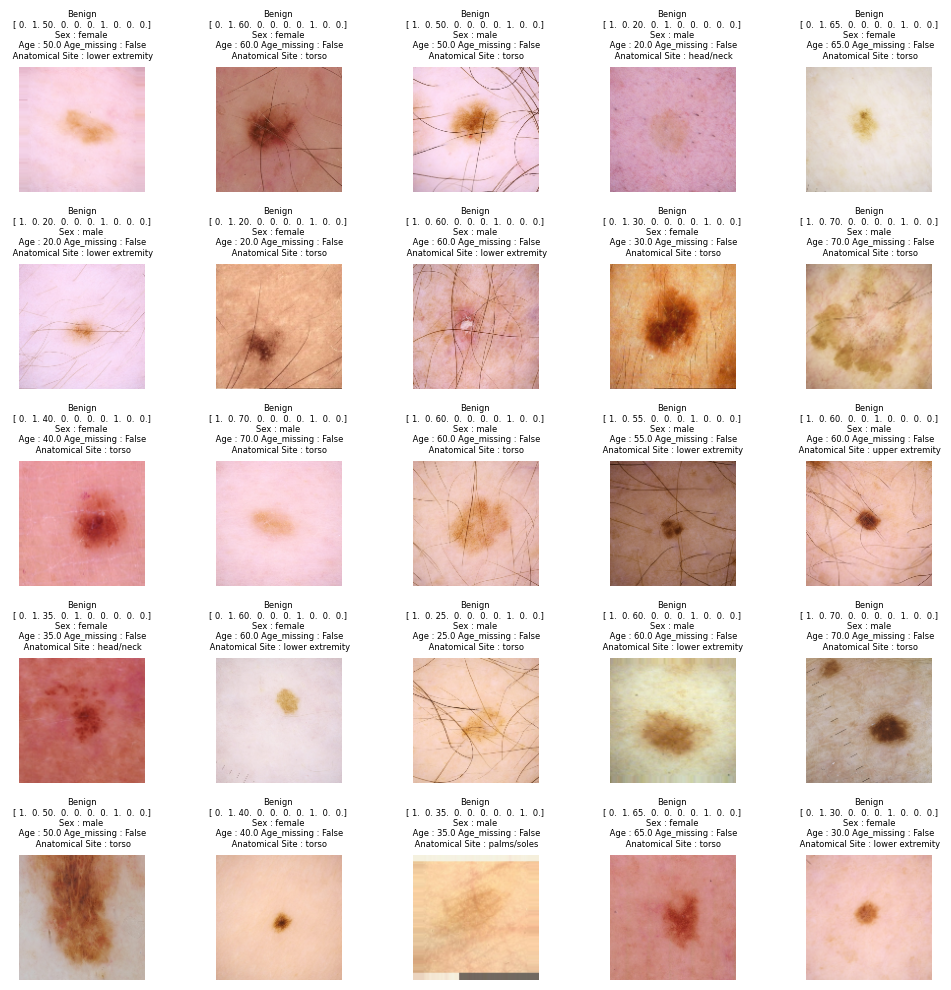

In [58]:
train_tabular_features, _ = get_tabular_features(train_data)
train_jpeg_dataset = get_training_dataset(tfrecord=False, 
                                          image_paths=train_data.image_path.values, 
                                          labels=train_data.target.values,
                                          tabular_data=train_tabular_features.values)
(image_batch, tab_data_batch), label_batch = next(iter(train_jpeg_dataset))
show_batch(image_batch.numpy(), tab_data_batch.numpy(), label_batch.numpy())

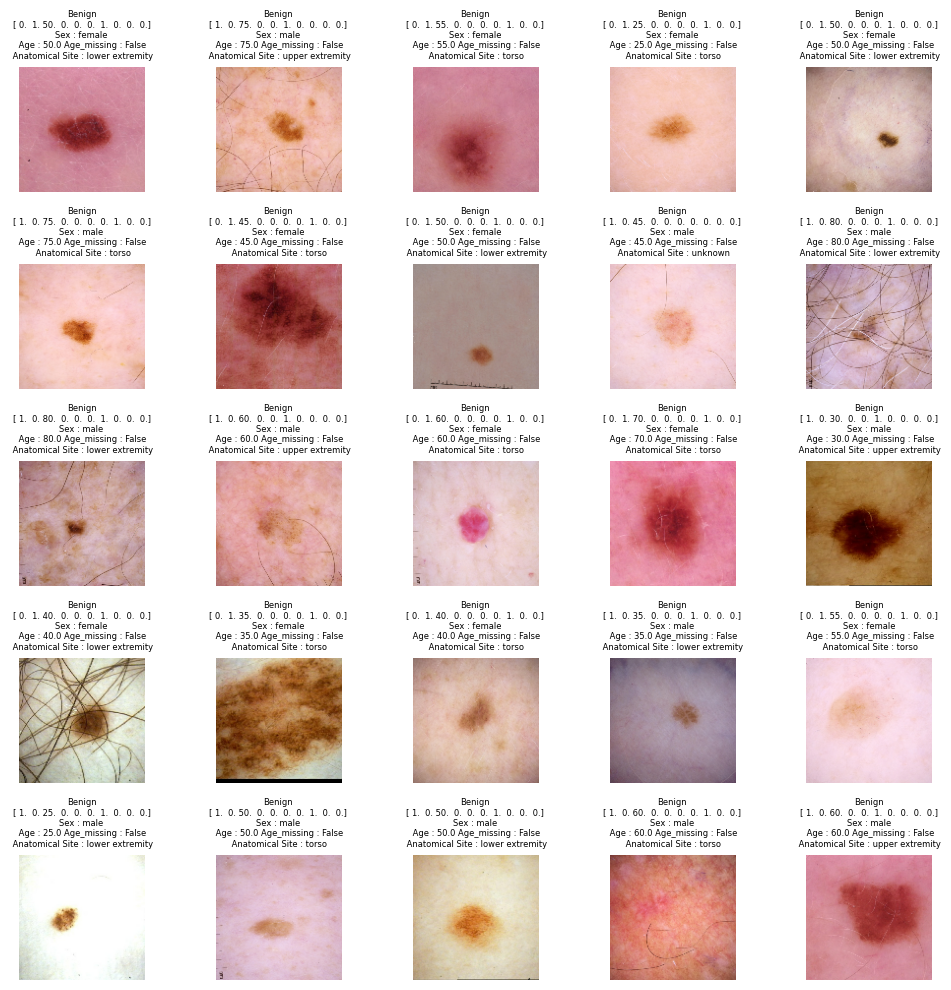

In [59]:
valid_tabular_features, _ = get_tabular_features(valid_data)
valid_jpeg_dataset = get_validation_dataset(tfrecord=False,
                                            image_paths=valid_data.image_path.values,
                                            labels=valid_data.target.values,
                                            tabular_data=valid_tabular_features.values)
(image_batch, tab_data_batch), label_batch = next(iter(valid_jpeg_dataset))
show_batch(image_batch.numpy(), tab_data_batch.numpy(), label_batch.numpy())

# Model creation and training

In [60]:
if TRAIN_ON_FULL_DATA or TRAIN_VALID_SPLIT:

    # Image Model
    base_model = keras.applications.EfficientNetV2S(
        include_top=False,
        input_shape=(*IMAGE_RESIZE, 3),
        include_preprocessing=True
    )
    # base_model = keras.applications.ConvNeXtTiny(
    #     include_top=False,
    #     input_shape=(*IMAGE_RESIZE, 3),
    #     include_preprocessing=True
    # )
    base_model.trainable = False
    for layer in base_model.layers[287:]:  
        layer.trainable = True  
    image_inputs = Input(shape=(*IMAGE_RESIZE, 3))
    x = base_model(image_inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Tabular Model
    tabular_inputs = Input(shape=(TABULAR_FEATURE_DIM,))
    t = layers.BatchNormalization()(tabular_inputs)
    # t = layers.Dense(4, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(t)
    # t = layers.BatchNormalization()(t)

    #Merge image and tabular
    merged = layers.Concatenate()([x, t])
    merged = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(merged)
    merged = layers.BatchNormalization()(merged)
    merged = layers.Dropout(0.2)(merged)
    merged = layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(merged)
    merged = layers.BatchNormalization()(merged)
    outputs = layers.Dense(1, activation='sigmoid')(merged)        
    
    model = keras.Model([image_inputs, tabular_inputs], outputs)
    
    model.summary(show_trainable=True)

In [61]:
if TRAIN_VALID_SPLIT:
    steps_per_epoch = int(np.ceil(train_data.shape[0] / BATCH_SIZE))
elif TRAIN_ON_FULL_DATA:
    steps_per_epoch = int(np.ceil(train.shape[0] / BATCH_SIZE))

In [62]:
if TRAIN_ON_FULL_DATA or TRAIN_VALID_SPLIT:

    initial_lr = 1e-3
    warmup_target_lr = 1e-2
    final_target_lr = 1e-4
    warmup_epochs = 5
    alpha = final_target_lr / warmup_target_lr
    decay_epochs = STAGE1_EPOCHS - warmup_epochs
    lr_scheduler = optimizers.schedules.CosineDecay(
        initial_learning_rate = initial_lr,
        warmup_target = warmup_target_lr,
        warmup_steps = steps_per_epoch * warmup_epochs,
        alpha = alpha,
        decay_steps = steps_per_epoch * decay_epochs,
    )
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr_scheduler),
        loss=keras.losses.BinaryFocalCrossentropy(gamma = 1.0, label_smoothing=0.05),  
        metrics=[metrics.AUC(), metrics.Recall(), metrics.Precision()]
    )

In [63]:
def plot_lr_scheduler(lr_scheduler, total_epochs):
	#step-wise
	steps = np.arange(steps_per_epoch * total_epochs)
	lr_values = [lr_scheduler(step).numpy() for step in steps]
	
	# epoch-wise
	epochs = np.arange(total_epochs)
	epoch_lr_values = [lr_scheduler(epoch * steps_per_epoch).numpy() for epoch in epochs]
	
	# Plot step-wise and epoch-wise learning rate schedules side by side
	fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
	
	# step-wise LR plot
	axes[0].plot(steps, lr_values, label="LR per Step", color="b")
	axes[0].set_xlabel("Steps")
	axes[0].set_ylabel("Learning Rate")
	axes[0].set_title("Step-wise Learning Rate Schedule")
	axes[0].set_yscale("log")
	axes[0].legend()
	axes[0].grid(True, which="both", linestyle="--")
	
	# epoch-wise LR plot
	axes[1].plot(epochs, epoch_lr_values, marker='o', linestyle='dotted', label="LR per Epoch", color="g")
	axes[1].set_xlabel("Epochs")
	axes[1].set_title("Epoch-wise Learning Rate Schedule")
	axes[1].set_yscale("log")
	axes[1].legend()
	axes[1].grid(True, which="both", linestyle="--")
	
	# Show plots
	plt.tight_layout()
	plt.show()

In [64]:
if TRAIN_ON_FULL_DATA or TRAIN_VALID_SPLIT:
    plot_lr_scheduler(lr_scheduler, STAGE1_EPOCHS)

## With train and validation

In [65]:
if TRAIN_VALID_SPLIT:
    #Load the train and valid dataset again, since we have iterated over them to show_batch
    train_jpeg_dataset = get_training_dataset(tfrecord=False, 
                                              image_paths=train_data.image_path.values, 
                                              labels=train_data.target.values,
                                              tabular_data=train_tabular_features.values)
    valid_jpeg_dataset = get_validation_dataset(tfrecord=False,
                                                image_paths=valid_data.image_path.values,
                                                labels=valid_data.target.values,
                                                tabular_data=valid_tabular_features.values)

    # Get class weights since the data is highly unbalanced
    class_weights = compute_class_weight('balanced', classes=np.array([0, 1]),
                                         y=train_data.target.values)
    class_weights_dict = {0: round(class_weights[0], 3), 1: round(class_weights[1], 3)}
    # print(class_weights_dict)
    # {0: 0.509, 1: 28.479}
    
    history = model.fit(train_jpeg_dataset, 
                        epochs=STAGE1_EPOCHS,
                        validation_data=valid_jpeg_dataset,
                        class_weight=class_weights_dict)

In [66]:
if TRAIN_VALID_SPLIT:
    history_frame = pd.DataFrame(history.history)
    display(history_frame)
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0,0])
    history_frame.loc[:, ['auc', 'val_auc']].plot(ax=axes[0,1])
    history_frame.loc[:, ['precision', 'val_precision']].plot(ax=axes[1,0])
    history_frame.loc[:, ['recall', 'val_recall']].plot(ax=axes[1,1])
    history_frame.loc[:, ['precision', 'recall']].plot(ax=axes[2,0])
    history_frame.loc[:, ['val_precision', 'val_recall']].plot(ax=axes[2,1])
    plt.tight_layout()
    plt.show()

## With full data

In [67]:
if TRAIN_ON_FULL_DATA:
    #Load the dataset again, since we have iterated over it to show_batch
    _, train_hash = get_tabular_features(train)
    train_dataset = get_training_dataset(filenames=train_filenames, tabular_data=train_hash)

    class_weights = compute_class_weight('balanced', classes=np.array([0, 1]),
                                         y=train.target.values)
    class_weights_dict = {0: round(class_weights[0], 3), 1: round(class_weights[1], 3)}
    # print(class_weights_dict)
    # {0: 0.509, 1: 28.361}    
    
    history = model.fit(train_dataset, 
                        epochs=STAGE1_EPOCHS,
                        class_weight=class_weights_dict)

In [68]:
if TRAIN_ON_FULL_DATA:
    history_frame = pd.DataFrame(history.history)
    display(history_frame)
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    history_frame.loc[:, ['auc']].plot(ax=axes[0,0])
    history_frame.loc[:, ['loss']].plot(ax=axes[0,1])
    history_frame.loc[:, ['precision']].plot(ax=axes[1,0])
    history_frame.loc[:, ['recall']].plot(ax=axes[1,1])
    plt.tight_layout()
    plt.show()

In [69]:
if TRAIN_ON_FULL_DATA:
    model.save(MODEL_STAGE1_FILE_NAME)

# Stage 2 train

In [70]:
# for i, layer in enumerate(base_model.layers):
#     if "block4a_expand_conv" in layer.name or"block5a_expand_conv" in layer.name or "block6a_expand_conv" in layer.name or "block6n_expand_conv" in layer.name:
#         print(f"Layer index: {i}, Layer name: {layer.name}")
# print(len(base_model.layers))

# # Layer index: 66, Layer name: block4a_expand_conv
# # Layer index: 154, Layer name: block5a_expand_conv
# # Layer index: 287, Layer name: block6a_expand_conv
# # Layer index: 480, Layer name: block6n_expand_conv
# # 513

In [71]:
if (TRAIN_ON_FULL_DATA or TRAIN_VALID_SPLIT) and STAGE2:
    # for layer in base_model.layers[287:]:  
    #     layer.trainable = True  
    # base_model.trainable = True
    for layer in base_model.layers[66:]:  
        layer.trainable = True      
    model.summary(show_trainable=True)

    initial_lr = 1e-4
    warmup_target_lr = 1e-3
    final_target_lr = 1e-5
    warmup_epochs = 4
    alpha = final_target_lr / warmup_target_lr
    decay_epochs = STAGE2_EPOCHS - warmup_epochs
    lr_scheduler = optimizers.schedules.CosineDecay(
        initial_learning_rate = initial_lr,
        warmup_target = warmup_target_lr,
        warmup_steps = steps_per_epoch * warmup_epochs,
        alpha = alpha,
        decay_steps = steps_per_epoch * decay_epochs,
    )
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr_scheduler),
        loss=keras.losses.BinaryFocalCrossentropy(gamma = 1.0, label_smoothing=0.05),  
        metrics=[metrics.AUC(), metrics.Recall(), metrics.Precision()]
    )

In [72]:
if (TRAIN_ON_FULL_DATA or TRAIN_VALID_SPLIT) and STAGE2:
    plot_lr_scheduler(lr_scheduler, STAGE2_EPOCHS)

## Stage 2 with train and validation

In [73]:
if TRAIN_VALID_SPLIT and STAGE2:
    history = model.fit(train_jpeg_dataset, 
                        epochs=STAGE2_EPOCHS,
                        validation_data=valid_jpeg_dataset,
                        class_weight=class_weights_dict)

In [74]:
if TRAIN_VALID_SPLIT and STAGE2:
    history_frame = pd.DataFrame(history.history)
    display(history_frame)
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0,0])
    history_frame.loc[:, ['auc_1', 'val_auc_1']].plot(ax=axes[0,1])
    history_frame.loc[:, ['precision_1', 'val_precision_1']].plot(ax=axes[1,0])
    history_frame.loc[:, ['recall_1', 'val_recall_1']].plot(ax=axes[1,1])
    history_frame.loc[:, ['precision_1', 'recall_1']].plot(ax=axes[2,0])
    history_frame.loc[:, ['val_precision_1', 'val_recall_1']].plot(ax=axes[2,1])
    plt.tight_layout()
    plt.show()

## Stage 2 with full data

In [75]:
if TRAIN_ON_FULL_DATA and STAGE2: 
    history = model.fit(train_dataset, 
                        epochs=STAGE2_EPOCHS,
                        class_weight=class_weights_dict)

In [76]:
if TRAIN_ON_FULL_DATA and STAGE2:
    history_frame = pd.DataFrame(history.history)
    display(history_frame)
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    history_frame.loc[:, ['auc']].plot(ax=axes[0,0])
    history_frame.loc[:, ['loss']].plot(ax=axes[0,1])
    history_frame.loc[:, ['precision']].plot(ax=axes[1,0])
    history_frame.loc[:, ['recall']].plot(ax=axes[1,1])
    plt.tight_layout()
    plt.show()

In [77]:
if TRAIN_ON_FULL_DATA and STAGE2:
    model.save(MODEL_STAGE2_FILE_NAME)    

# Predict on test data

In [78]:
if TEST_PREDICT:
    model = keras.models.load_model(MODEL_LOAD_FILE_PATH)
    model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1          │ (None, 128, 128, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ efficientnetv2-s       │ (None, 4, 4, 1280)   │   20,331,360 │ input_layer_1[0][0] │    N    │
│ (Functional)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 1280)         │            0 │ efficientnetv2-s[0… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 1280)         │        5,120 │ global_average_poo… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ input_layer_2          │ (None, 10)           │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout (Dropout)      │ (None, 1280)         │            0 │ batch_normalizatio… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 10)           │           40 │ input_layer_2[0][0] │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ concatenate            │ (None, 1290)         │            0 │ dropout[0][0],      │    -    │
│ (Concatenate)          │                      │              │ batch_normalizatio… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense (Dense)          │ (None, 128)          │      165,248 │ concatenate[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 128)          │          512 │ dense[0][0]         │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout_1 (Dropout)    │ (None, 128)          │            0 │ batch_normalizatio… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_1 (Dense)        │ (None, 16)           │        2,064 │ dropout_1[0][0]     │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 16)           │           64 │ dense_1[0][0]       │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_2 (Dense)        │ (None, 1)            │           17 │ batch_normalizatio… │    Y    │
└────────────────────────┴──────────────────────┴──────────────┴─────────────────────┴─────────┘

 Total params: 50,628,964 (193.13 MB)

 Trainable params: 15,062,269 (57.46 MB)

 Non-trainable params: 5,442,156 (20.76 MB)

 Optimizer params: 30,124,539 (114.92 MB)

In [79]:
if TEST_PREDICT:
    _, test_hash = get_tabular_features(test)
    test_dataset = get_test_dataset(filenames=test_filenames, tabular_data=test_hash)

    # # The below commented code unfortunately fails, eventhough for 1 batch it works fine.
    # # So converting dataset to NumPy array and executing model.predict 
    # test_dataset_noname = test_dataset.map(lambda data, idnum: data)
    # prediction_prob = model.predict(test_dataset_noname, steps=int(np.ceil(num_test_images / BATCH_SIZE)))
        
    test_image, test_tab_data, test_image_name = [], [], [] 
    for (image_batch, tab_data_batch), image_name_batch in test_dataset.as_numpy_iterator():
        test_image.append(image_batch)
        test_tab_data.append(tab_data_batch)
        test_image_name.append([image_name.decode("utf-8") for image_name in image_name_batch]) 
    test_image = np.concatenate(test_image, axis=0)
    test_tab_data = np.concatenate(test_tab_data, axis=0)
    test_image_name = np.concatenate(test_image_name, axis=0)
    
    print(test_image.shape, test_tab_data.shape, test_image_name.shape)
    
    prediction_prob = model.predict((test_image, test_tab_data), batch_size=BATCH_SIZE_TEST)

(10982, 128, 128, 3) (10982, 10) (10982,)
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 458ms/step


# Create submission file

In [80]:
if TEST_PREDICT:
    submission = pd.DataFrame(dict(image_name=test_image_name, target=prediction_prob[:, 0]))
    submission = submission.sort_values('image_name') 
    submission.to_csv('submission.csv', index=False)
    !head submission.csv

image_name,target
ISIC_0052060,0.15448238
ISIC_0052349,0.13029912
ISIC_0058510,0.03833355
ISIC_0073313,0.037534054
ISIC_0073502,0.06551923
ISIC_0074618,0.28858465
ISIC_0076801,0.08523173
ISIC_0077586,0.58920324
ISIC_0082004,0.08842713


# References
* https://www.kaggle.com/code/jessemostipak/getting-started-tpus-cassava-leaf-disease
* https://www.kaggle.com/code/amyjang/tensorflow-transfer-learning-melanoma
* https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords
* https://www.kaggle.com/code/ibtesama/siim-baseline-keras-vgg16
* https://www.kaggle.com/competitions/siim-isic-melanoma-classification/discussion/164092
* https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155579
